# Robustness of policies

In [1]:
# read in all the needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from ema_workbench.analysis import parcoords
from ema_workbench import (MultiprocessingEvaluator, Policy)
from ema_workbench.util import ema_logging

plt.rcParams['figure.figsize'] = [20, 10] # set figure size

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)

C:\Users\thori\Anaconda3\envs\mbdm1\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


## Re-evaluate under deep uncertainty

The results from the optimisation are read in. Only policies i.e. lever combinations are kept, that result in less than 0.01 expected deaths for A.5 Deventer. This ensures that all lever combinations that are considered for policies actually perform well over the worst case scenarios.

In [2]:
results = []
for i in range(5):
    results_scenario = pd.read_csv(f'outcomes/15k_results_optimisation_scenario{i}.csv')
    results_scenario = results_scenario[results_scenario['A.5_Expected Number of Deaths'] <= 1]
    results.append(results_scenario)

In [3]:
results[3].columns

Index(['Unnamed: 0', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

Following, the results for the 4 other dike rings (non-Deventer) are added up. This is due to the comparison between Deventer and the rest. Results for dike ring 4 (Gorssel) are kept to be able to directly compare Deventer's results to those of its neighbour Gorssel.

In [4]:
for i in range(len(results)):
    results[i]['Other Areas Total Number of Deaths'] = 0  
    results[i]['Other Areas Total Costs'] = 0
    results[i]['Scenario number'] = i
    
    for area in range(1,5):
        results[i]['Other Areas Total Number of Deaths'] += results[i][f'A.{area}_Expected Number of Deaths']
        results[i]['Other Areas Total Costs'] += results[i][f'A.{area} Total Costs']
    
    results[i] = results[i].drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

In [5]:
# add all the results to one dataframe
combined_results = results[0].append([results[1], results[2], results[3], results[4]], ignore_index=True)

In [7]:
# sort by number of deaths A.5
combined_results.sort_values('A.5_Expected Number of Deaths').head()

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0           0        0        1        0        0        0        0        0   
3921        1        1        1        0        1        0        0        1   
7917        0        0        0        0        0        1        0        0   
7916        0        0        0        0        0        0        0        0   
7915        0        0        0        0        0        1        1        0   

      2_RfR 2  3_RfR 0  ...  A.5_DikeIncrease 2  A.4 Total Costs  \
0           1        1  ...                   5     2.078505e+07   
3921        1        1  ...                   0     6.880634e+07   
7917        1        1  ...                   3     1.854588e+07   
7916        1        1  ...                   0     1.426165e+07   
7915        0        0  ...                   6     9.695195e+06   

      A.4_Expected Number of Deaths  A.5 Total Costs  \
0                               0.0     1.462890e+08   
3921                            0.0     8.817544e+07   
7917                            0.0     1.421922e+08   
7916                            0.0     5.817663e+07   
7915                            0.0     1.487124e+08   

      A.5_Expected Number of Deaths  RfR Total Costs  \
0                               0.0     4.789000e+08   
3921                            0.0     1.664900e+09   
7917                            0.0     6.121000e+08   
7916                            0.0     6.504000e+08   
7915                            0.0     4.909000e+08   

      Expected Evacuation Costs  Other Areas Total Number of Deaths  \
0                    244.264995                            0.001020   
3921                1632.460355                            0.004847   
7917                 222.894080                            0.000718   
7916                 122.900820                            0.001601   
7915                1111.046162                            0.002302   

      Other Areas Total Costs  Scenario number  
0                2.226703e+08                0  
3921             5.832458e+08                1  
7917             1.701218e+08                4  
7916             2.780917e+08                4  
7915             2.392165e+08                4  

[5 rows x 40 columns]

From the 5 scenarios that were put into the optimisation (see notebook multi-scenario MORDM.ipynb), the maximum i.e. worst values for each of those scenarios for each column as well as the minimum i.e. best outcomes for those 5 optimised scenarios are taken. Then, the experiments matching those outcomes are are stored. 

In [8]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs']


lever_array = outcomes_array + ['Scenario number']

result_best_worst_scenarios = []
for i in range(len(results)):
    result_best_worst = []
    result_worst = results[i].loc[results[i][outcomes_array].idxmax()]

    result_best = results[i].loc[results[i][outcomes_array].idxmin()]

    result_best_worst = result_best.append(result_worst)
    
    result_best_worst = result_best_worst.drop(lever_array, axis=1)
    result_best_worst_scenarios.append(result_best_worst)

In [9]:
len(result_best_worst_scenarios)

5

In [10]:
# append to one dataframe
result_best_worst_all = result_best_worst_scenarios[0].append([result_best_worst_scenarios[1], result_best_worst_scenarios[2], result_best_worst_scenarios[3], result_best_worst_scenarios[4]], ignore_index=True)
result_best_worst_all

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        1        0        0        1        0        1   
1         0        0        1        0        0        0        0        0   
2         0        1        0        0        0        0        0        0   
3         0        0        1        0        0        0        0        0   
4         0        0        0        0        0        0        0        0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
75        0        0        0        0        0        0        1        1   
76        1        1        1        1        0        1        1        1   
77        0        0        0        0        0        0        1        1   
78        0        0        1        0        0        0        1        0   
79        1        0        0        0        0        0        1        0   

    2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
0         0        1  ...                   4                   3   
1         1        1  ...                   3                   0   
2         0        1  ...                   1                   0   
3         1        1  ...                   3                   0   
4         0        0  ...                   5                   5   
..      ...      ...  ...                 ...                 ...   
75        0        0  ...                   0                   5   
76        1        1  ...                   2                   4   
77        1        0  ...                   3                   1   
78        0        0  ...                   2                   0   
79        0        0  ...                   6                   5   

    A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0                    0                   5                   3   
1                    0                   0                   4   
2                    0                   0                   4   
3                    0                   0                   4   
4                    0                   4                   6   
..                 ...                 ...                 ...   
75                   3                   0                   4   
76                   1                   7                   2   
77                   1                   3                   4   
78                   0                   1                   6   
79                   5                   9                   1   

    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                    0                   0                   1   
1                    0                   4                  10   
2                    6                   6                   7   
3                    0                   4                  10   
4                    1                   3                   6   
..                 ...                 ...                 ...   
75                   0                   1                   1   
76                   0                   0                   7   
77                   0                   4                   0   
78                   0                   0                   9   
79                   1                   7                  10   

    A.5_DikeIncrease 1  A.5_DikeIncrease 2  
0                    4                   3  
1                    1                   5  
2                    0                   0  
3                    1                   5  
4                    2                   6  
..                 ...                 ...  
75                   2                   1  
76                   3                   6  
77                   2                   0  
78                   2                   2  
79                   7                   1  

[80 rows x 31 columns]

It results, that some experiments are the same. Duplicates will be removed. Then, out of those experiments policies are created. 

In [11]:
duplicateDFRow = result_best_worst_all[result_best_worst_all.duplicated()]
result_best_worst_all_no_duplicates = result_best_worst_all.drop(duplicateDFRow.index)

In [12]:
result_best_worst_all_no_duplicates

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        1        0        0        1        0        1   
1         0        0        1        0        0        0        0        0   
2         0        1        0        0        0        0        0        0   
4         0        0        0        0        0        0        0        0   
5         0        1        1        0        0        0        1        0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
74        0        0        0        0        0        0        1        1   
75        0        0        0        0        0        0        1        1   
76        1        1        1        1        0        1        1        1   
78        0        0        1        0        0        0        1        0   
79        1        0        0        0        0        0        1        0   

    2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
0         0        1  ...                   4                   3   
1         1        1  ...                   3                   0   
2         0        1  ...                   1                   0   
4         0        0  ...                   5                   5   
5         0        1  ...                   5                   1   
..      ...      ...  ...                 ...                 ...   
74        1        0  ...                   3                   1   
75        0        0  ...                   0                   5   
76        1        1  ...                   2                   4   
78        0        0  ...                   2                   0   
79        0        0  ...                   6                   5   

    A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0                    0                   5                   3   
1                    0                   0                   4   
2                    0                   0                   4   
4                    0                   4                   6   
5                    6                   0                   4   
..                 ...                 ...                 ...   
74                   1                   3                   4   
75                   3                   0                   4   
76                   1                   7                   2   
78                   0                   1                   6   
79                   5                   9                   1   

    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                    0                   0                   1   
1                    0                   4                  10   
2                    6                   6                   7   
4                    1                   3                   6   
5                    2                   0                   7   
..                 ...                 ...                 ...   
74                   0                   4                   0   
75                   0                   1                   1   
76                   0                   0                   7   
78                   0                   0                   9   
79                   1                   7                  10   

    A.5_DikeIncrease 1  A.5_DikeIncrease 2  
0                    4                   3  
1                    1                   5  
2                    0                   0  
4                    2                   6  
5                    0                   5  
..                 ...                 ...  
74                   2                   0  
75                   2                   1  
76                   3                   6  
78                   2                   2  
79                   7                   1  

[66 rows x 31 columns]

In [13]:
# create policies according to those levers
policies = []
for j, row in result_best_worst_all_no_duplicates.iterrows():
        policy = Policy(f'scenario option {j}', **row.to_dict())
        policies.append(policy)

These policies represent the policies that perform best and worst over the worst-case scenarios but still meet the set threshold of 0.01 deaths in Deventer. 1000 scenarios are run with these policies to explore each policy's robustness.

In [15]:
# run re-evaluation with 1000 scenarios for those 66 found policies
ema_logging.log_to_stderr(level='INFO')


with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 66 policies * 1 model(s) = 66000 experiments
[MainProcess/INFO] 6600 cases completed
[MainProcess/INFO] 13200 cases completed
[MainProcess/INFO] 19800 cases completed
[MainProcess/INFO] 26400 cases completed
[MainProcess/INFO] 33000 cases completed
[MainProcess/INFO] 39600 cases completed
[MainProcess/INFO] 46200 cases completed
[MainProcess/INFO] 52800 cases completed
[MainProcess/INFO] 59400 cases completed
[MainProcess/INFO] 66000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
experiments = reeevaluation_results[0]
results = pd.DataFrame(reeevaluation_results[1])

In [17]:
# save to csv so it can be read in later
results.to_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments.to_csv('./outcomes/reevaluation_promising_experiments.csv')


# Analysis
In this section, first the results from the previous run are read in. Then, the policies will be evaluated considering robustness. The robustness metrics Maximin and Minimax regret will be used. 

In [14]:
# read in results
results_load = pd.read_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments_load = pd.read_csv('./outcomes/reevaluation_promising_experiments.csv')

In [15]:
# adapt dataframes slightly: combine A.1 to A.4 for comparison reasons, 
# delete no longer needed columns (A.1 to A.3, A.4 kept for direct comparison)
results_load['Other Areas Total Number of Deaths'] = 0  
results_load['Other Areas Total Costs'] = 0

for area in range(1,5):
    results_load['Other Areas Total Number of Deaths'] += results_load[f'A.{area}_Expected Number of Deaths']
    results_load['Other Areas Total Costs'] += results_load[f'A.{area} Total Costs']

results_load = results_load.drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
   'A.2_Expected Number of Deaths', 'A.3 Total Costs',
   'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

The sum of dike increase over the three timesteps is added here. The reason is, that Deventer does not want to increase its dikes because it would destroy part of its beautiful historical city center. Therefore, this is included here and also evaluated regarding maximin robustness.

In [16]:
experiments_load['A.5_total_dike_increase'] = 0

for time_step in range(3):
    experiments_load['A.5_total_dike_increase'] += experiments_load[f'A.5_DikeIncrease {time_step}']
experiments_load.head()

Unnamed: 0  A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail  \
0           0                    108.0  306.204867       10.0   0.200822   
1           1                     71.0  232.607582        1.5   0.155764   
2           2                     21.0  348.831088        1.0   0.196232   
3           3                      9.0  189.760125       10.0   0.339976   
4           4                    115.0  217.057027        1.5   0.826048   

     A.2_Bmax  A.2_Brate  A.2_pfail    A.3_Bmax  A.3_Brate  ...  \
0  162.325922        1.5   0.791249  210.485682       10.0  ...   
1   90.103364       10.0   0.987325  111.572437       10.0  ...   
2  265.196139       10.0   0.288037  185.085407       10.0  ...   
3  204.933490        1.5   0.925791  199.394990       10.0  ...   
4  290.177029        1.0   0.493298  128.670483        1.5  ...   

   A.4_DikeIncrease 0  A.4_DikeIncrease 1  A.4_DikeIncrease 2  \
0                 3.0                 0.0                 0.0   
1                 3.0                 0.0                 0.0   
2                 3.0                 0.0                 0.0   
3                 3.0                 0.0                 0.0   
4                 3.0                 0.0                 0.0   

   A.5_DikeIncrease 0  A.5_DikeIncrease 1  A.5_DikeIncrease 2  scenario  \
0                 1.0                 4.0                 3.0         0   
1                 1.0                 4.0                 3.0         1   
2                 1.0                 4.0                 3.0         2   
3                 1.0                 4.0                 3.0         3   
4                 1.0                 4.0                 3.0         4   

              policy     model  A.5_total_dike_increase  
0  scenario option 0  dikesnet                      8.0  
1  scenario option 0  dikesnet                      8.0  
2  scenario option 0  dikesnet                      8.0  
3  scenario option 0  dikesnet                      8.0  
4  scenario option 0  dikesnet                      8.0  

[5 rows x 55 columns]

In [17]:
# rename the policys from 'scenario option xx' to 'policy xx'
experiments_load['policy'] = experiments_load['policy'].str.replace('scenario option', 'Policy')

In [18]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs', 'A.5_total_dike_increase']


lever_array = outcomes_array + ['Scenario number']

#### Functions for the further use
Since these steps occur numerous times throughout the analysis, following functions have been written:

In [19]:
# function to find which outcomes are dominated by others,
# takes in the policy outcomes, gives back the index of those that are dominated i.e. that can be dropped later

def dominate(policy_outcomes):
    
    todrop = []
    for i in range(len(policy_outcomes)):
        for j in range(len(policy_outcomes)):
            if j == i:
                pass
            else: # if all values of one policy greater than those of others
                dominated = policy_outcomes.iloc[i,:] >= policy_outcomes.iloc[j,:]
                if dominated.sum() == len(policy_outcomes.columns):
                    todrop.append(i)
    return np.unique(todrop)

In [20]:
# function to create a parallel axis plot and save the figure
# takes in dataframe with outcomes of policies (the dominated one, so not as many to plot)
# gives out plot and saves figure to figures-folder

def axes_paraplot(dominate_policy, pref, name_figure):
    
    policy_names = pref.index.values[dominate_policy.index.values] # for legend
    
    limits = parcoords.get_limits(dominate_policy)
    axes = parcoords.ParallelAxes(limits)
    dominate_policy = dominate_policy.reset_index(drop=True)
    for i in range(len(dominate_policy)):   
        axes.plot(dominate_policy.iloc[i], label=policy_names[i], color=sns.color_palette('hls', len(dominate_policy))[i])
    axes.legend()

    plt.savefig(f'./figures/{name_figure}.png', bbox_inches="tight")
    return policy_names

### Maximin
Maximin is taking into account the worst case scenario the worst thing that could happen.

"the maximin metric has a very high level of intrinsic risk aversion, as its calculation is only based on the worst performance over all scenarios considered (Table 3), leading to a very conservative solution (Bertsimas & Sim, 2004). Similarly, the minimax regret metric assumes that the selected decision alternative will have the largest regret possible, as its calculation is based on the worst-case relative performance" https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000649


In [21]:
policy_outcomes_maximin = results_load
policy_outcomes_maximin['policy'] = experiments_load['policy'] 
policy_outcomes_maximin['scenario'] = experiments_load['scenario'] 
policy_outcomes_maximin['A.5_total_dike_increase'] = experiments_load['A.5_total_dike_increase'] 

# find the maximin regret i.e the least preffered outcome under the policy (max, because we want to minimise everything)
least_pref = pd.DataFrame()
for outcome in outcomes_array:
    least_pref[outcome] = policy_outcomes_maximin.groupby(['policy']).max()[outcome]


In [22]:
# rename and reorder columns
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC', 'A.5Dike']
least_pref = least_pref.set_axis(short_names, axis=1)
least_pref = least_pref.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5Dike'])
least_pref = least_pref[least_pref['A.4_Deaths']<= 0.04]

#normalise values between 0 and 1 (mostly for visualisation and comparison reasons)
x_maximin = least_pref.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_maximin_scaled = min_max_scaler.fit_transform(x_maximin)
least_pref_norm = pd.DataFrame(x_maximin_scaled)


least_pref_norm = least_pref_norm.set_axis(short_names, axis=1)
least_pref_norm = least_pref_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5Dike'])


In [23]:
# split up datafram, one for A.4 vs A.5 and one for A.5 vs rest
least_pref_norm_45 = least_pref_norm[['A.4_Deaths', 'A.5_Deaths',  'A.4_TC', 'A.5_TC', 'A.5Dike']]
least_pref_norm_others5 = least_pref_norm[['A.5_Deaths', 'OTD', 'A.5_TC',  'OTC', 'RfR Costs', 'Evac C','A.5Dike']]

The results will be visualised below in Parallel Axis plots.

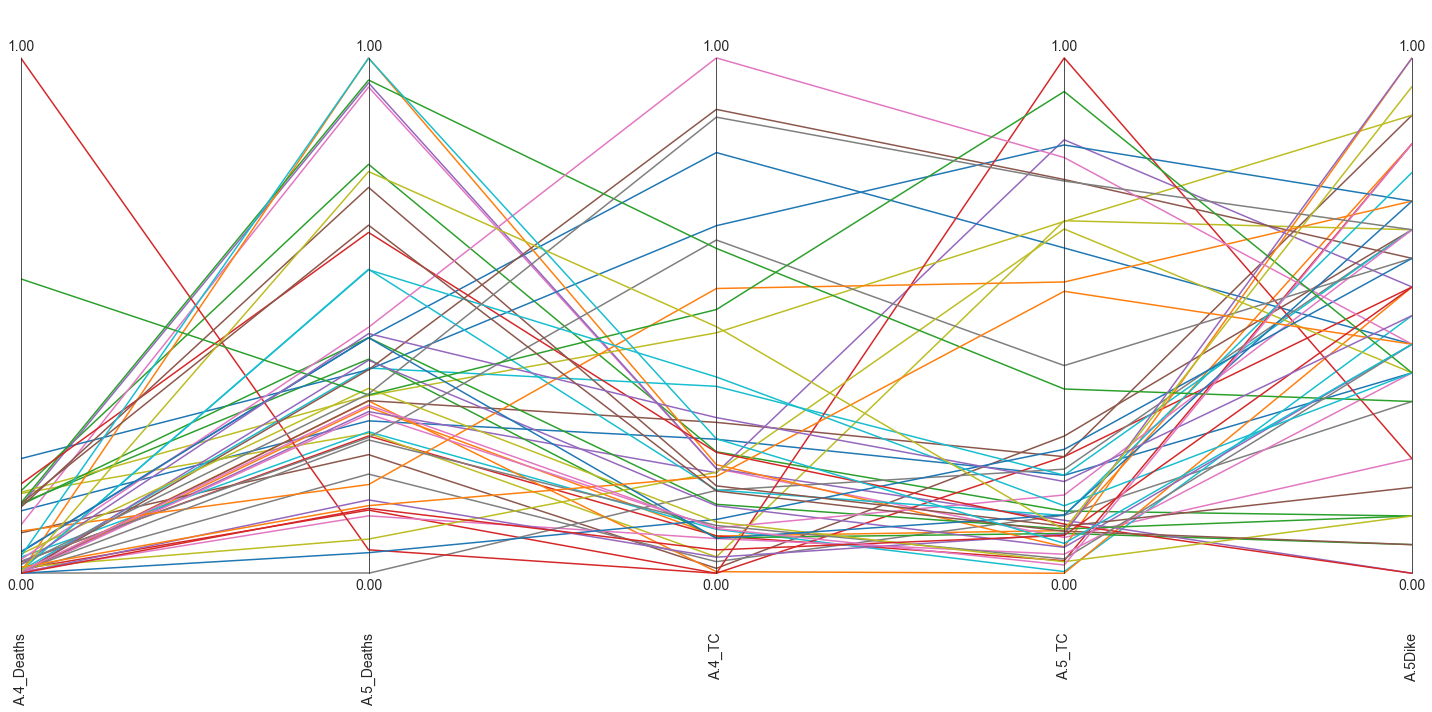

In [24]:
limits = parcoords.get_limits(least_pref_norm_45)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref_norm_45)
plt.savefig('./figures/maximin_norm_45_undominated.png')

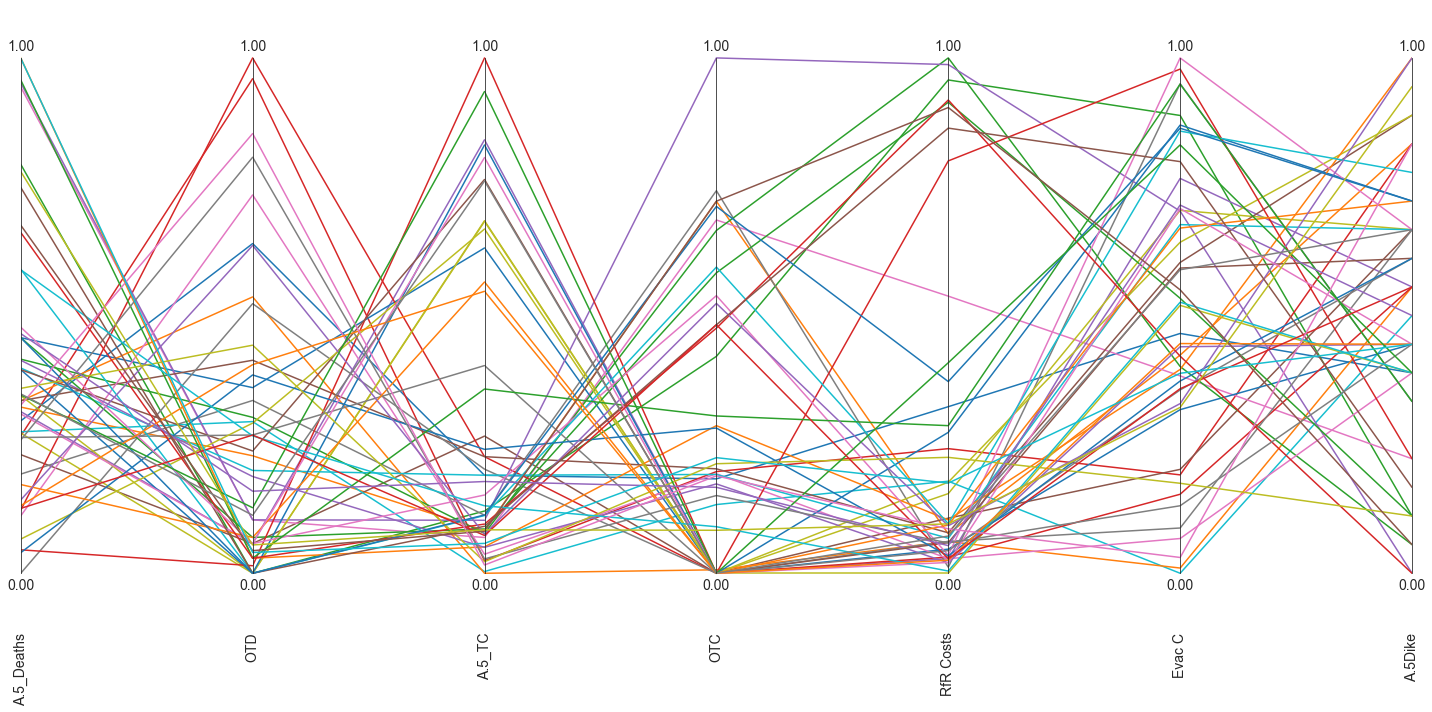

In [25]:
limits = parcoords.get_limits(least_pref_norm_others5)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref_norm_others5)
plt.savefig('./figures/maximin_norm_others5_undominated.png')

Since above it is not clear which policy is best, we remove policies by finding which are dominated by others and removing them. 

In [26]:
# create dataframe with resulting, dominating policies
least_pref_norm_45_dominate = least_pref_norm_45.drop(dominate(least_pref_norm_45))
least_pref_norm_others5_dominate = least_pref_norm_others5.drop(dominate(least_pref_norm_others5))

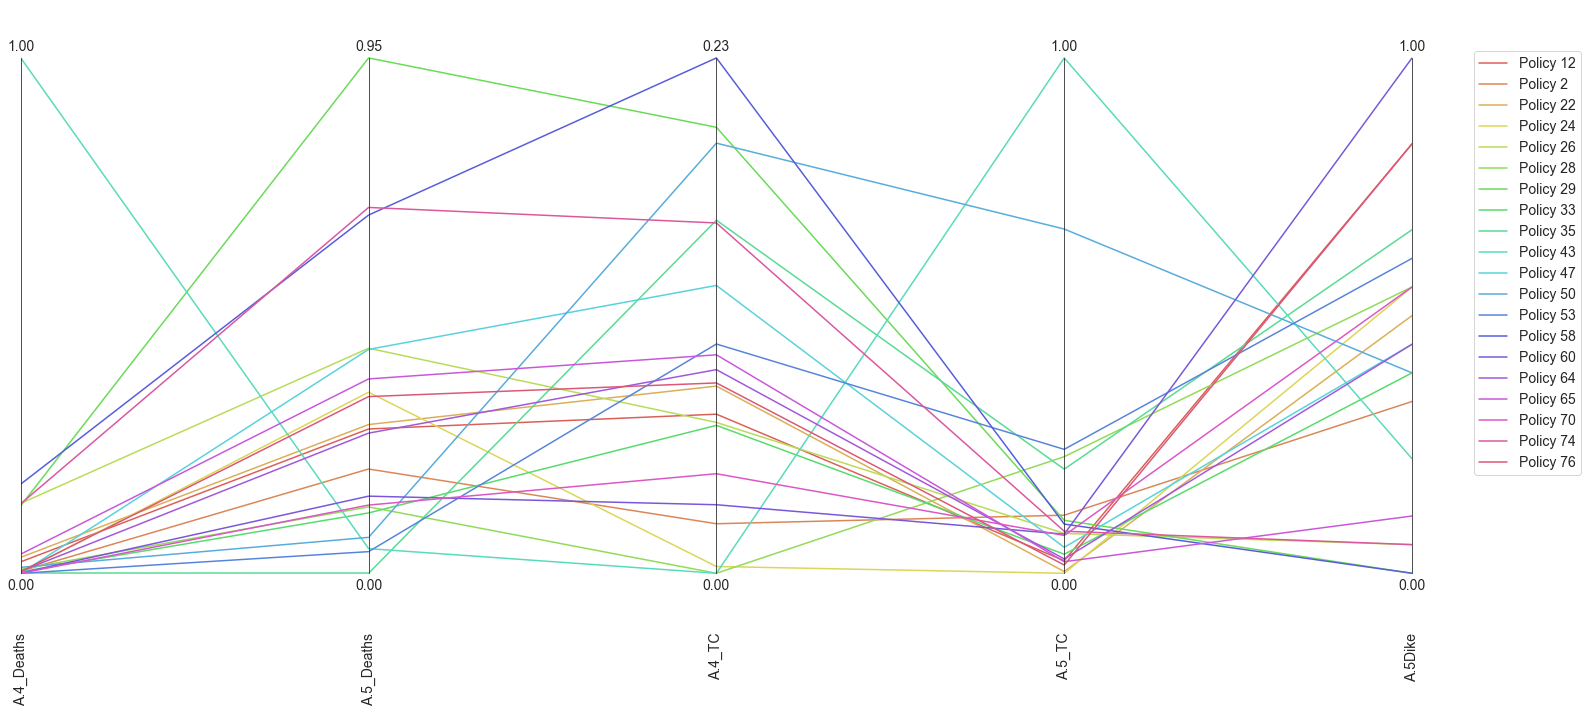

In [27]:
policies_maximin_45 = axes_paraplot(least_pref_norm_45_dominate, least_pref, 'maximin_norm_45_dominated')

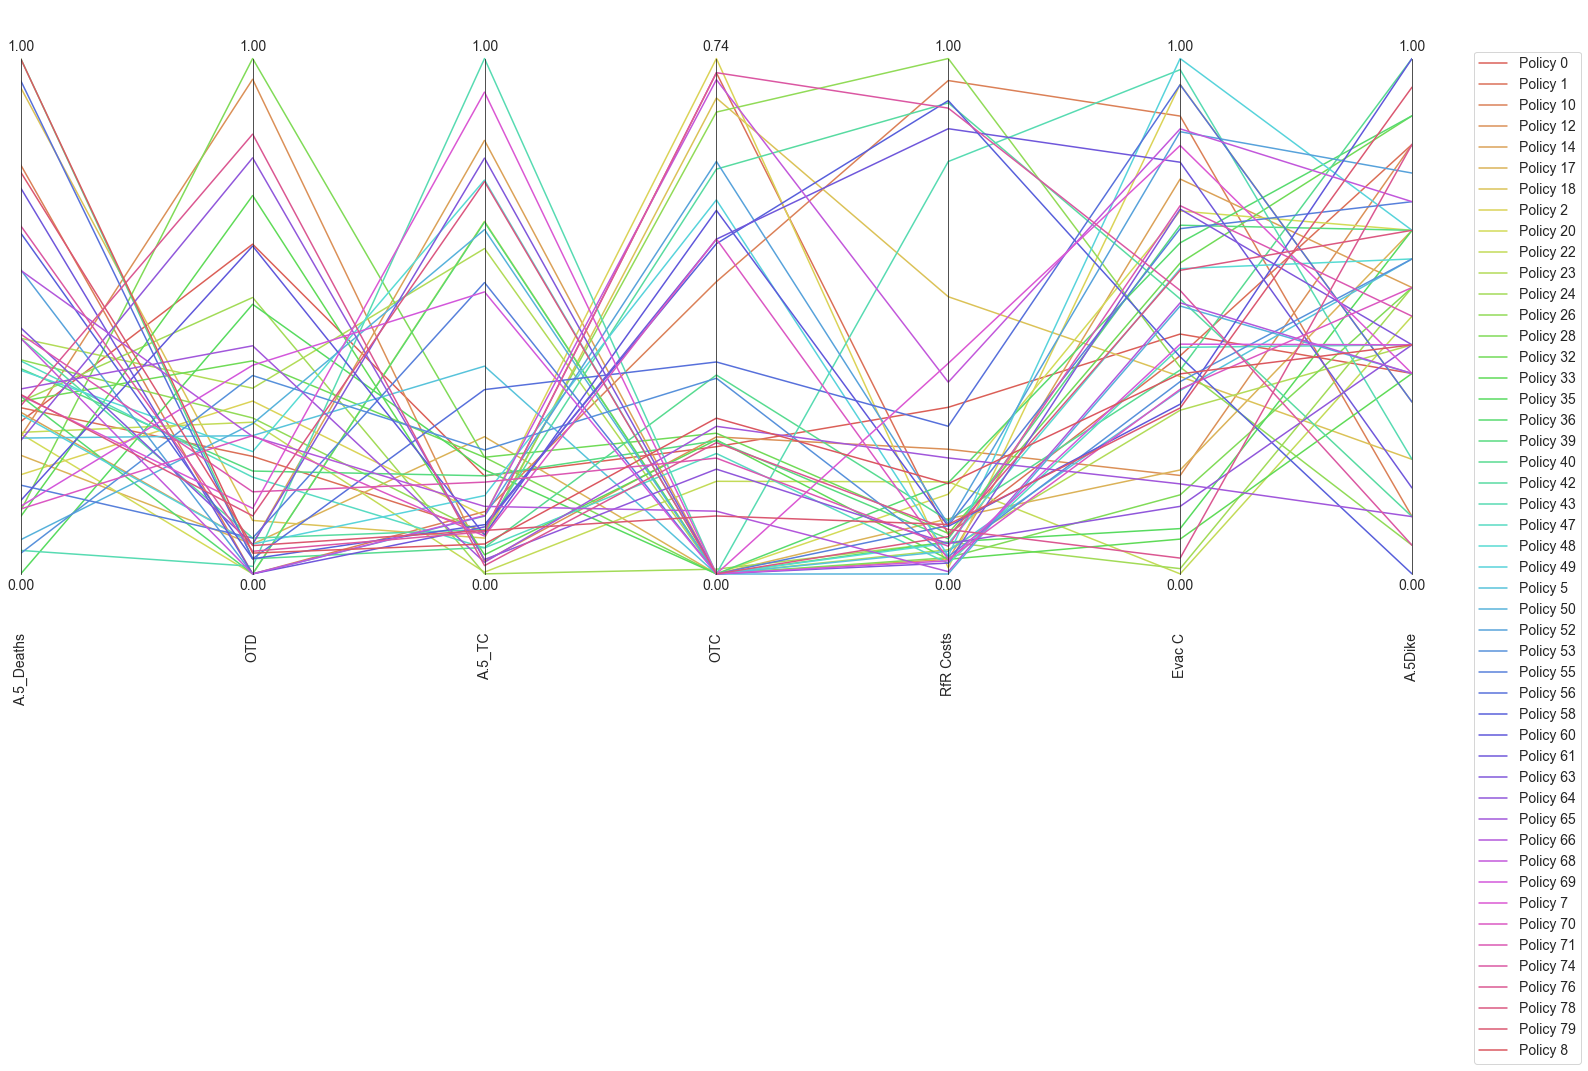

In [28]:
policies_maximin_others5 = axes_paraplot(least_pref_norm_others5_dominate, least_pref, 'maximin_norm_others5_dominated')

Above, the policies with the best maximin results that are dominating are plotted. The tradeoffs are visualised. Below, the corresponding policy numbers can be found.

In [29]:
policies_maximin_others5

array(['Policy 0', 'Policy 1', 'Policy 10', 'Policy 12', 'Policy 14',
       'Policy 17', 'Policy 18', 'Policy 2', 'Policy 20', 'Policy 22',
       'Policy 23', 'Policy 24', 'Policy 26', 'Policy 28', 'Policy 32',
       'Policy 33', 'Policy 35', 'Policy 36', 'Policy 39', 'Policy 40',
       'Policy 42', 'Policy 43', 'Policy 47', 'Policy 48', 'Policy 49',
       'Policy 5', 'Policy 50', 'Policy 52', 'Policy 53', 'Policy 55',
       'Policy 56', 'Policy 58', 'Policy 60', 'Policy 61', 'Policy 63',
       'Policy 64', 'Policy 65', 'Policy 66', 'Policy 68', 'Policy 69',
       'Policy 7', 'Policy 70', 'Policy 71', 'Policy 74', 'Policy 76',
       'Policy 78', 'Policy 79', 'Policy 8'], dtype=object)

In [30]:
policies_maximin_45

array(['Policy 12', 'Policy 2', 'Policy 22', 'Policy 24', 'Policy 26',
       'Policy 28', 'Policy 29', 'Policy 33', 'Policy 35', 'Policy 43',
       'Policy 47', 'Policy 50', 'Policy 53', 'Policy 58', 'Policy 60',
       'Policy 64', 'Policy 65', 'Policy 70', 'Policy 74', 'Policy 76'],
      dtype=object)

### Minimax Regret Criterion
The Minimax Regret Criterion is a technique used to make decisions under uncertainty. The context of a decision making process under uncertainty, a decision maker is faced to uncertain states of nature and a number of decision alternatives that can be chosen. The decision made and the final state of nature (which the decision maker does not know beforehand) determines the payoff.

Under this Minimax Regret Criterion, the decision maker calculates the maximum opportunity loss values (or also known as regret) for each alternative, and then she chooses the decision that has the lowest maximum regret.

The regret or opportunity loss for a specific alternative, at a given state of nature, is how much we lose by choosing that alternative and not the optimal alternative, given that state of nature (if the current alternative IS the optima alternative, then the opportunity loss for that alternative, given the state of nature, is 0).

https://mathcracker.com/minimax-regret-criterion-calculator

In [31]:
# same as above, create dataframe for the calculation of minimax regret
policy_outcomes = results_load
policy_outcomes_regret = results_load.copy()
# add scenario and policy to dataframe
policy_outcomes_regret['scenario'] = experiments_load['scenario']
policy_outcomes_regret['policy'] = experiments_load['policy']

# find the most prefered i.e., minimum outcomes for each policy
most_pref = pd.DataFrame()
for outcome in outcomes_array:
    most_pref[outcome] = policy_outcomes_regret.groupby(['policy']).min()[outcome] 

most_pref.reset_index(inplace=True)

In [123]:
# calculate the minimax regret through subtracting the ideal outcome of each policy from every other outcome. 
for i in range(len(policy_outcomes_regret)):
    for j in range(len(most_pref)):
        if policy_outcomes_regret['policy'][i] == most_pref['policy'][j]:
            for outcome in outcomes_array:
                policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]

<ipython-input-123-f1c685773121>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]


In [124]:
# save to csv in order to read in later to save run time
policy_outcomes_regret.to_csv('./outcomes/minimax_regret_outcomes.csv')

In [33]:
# read in minimax regret results
policy_outcomes_regret = pd.read_csv('./outcomes/minimax_regret_outcomes.csv')

In [34]:
# find the highest regret value for each policy i.e., the highest regret
worst_regret = policy_outcomes_regret.groupby('policy').max().drop(['scenario', 'Unnamed: 0', 'A.5_total_dike_increase'], axis=1)
worst_regret

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
policy                                                                       
Policy 0      7.152599e+07                       0.009499     3.371313e+08   
Policy 1      6.330480e+07                       0.002639     0.000000e+00   
Policy 10     1.396683e+08                       0.008613     1.090102e+09   
Policy 11     1.208078e+08                       0.052106     7.092075e+08   
Policy 12     6.813004e+07                       0.002646     2.040568e+08   
...                    ...                            ...              ...   
Policy 76     7.733379e+07                       0.003166     1.878788e+07   
Policy 78     7.545613e+07                       0.032331     1.116753e+07   
Policy 79     1.263225e+08                       0.017480     4.452985e+06   
Policy 8      1.809418e+08                       0.009533     1.815837e+08   
Policy 9      1.816341e+08                       0.064424     5.041310e+07   

           A.5_Expected Number of Deaths  RfR Total Costs  \
policy                                                      
Policy 0                        0.090317              0.0   
Policy 1                        0.000000              0.0   
Policy 10                       0.119143              0.0   
Policy 11                       0.590559              0.0   
Policy 12                       0.016587              0.0   
...                                  ...              ...   
Policy 76                       0.002461              0.0   
Policy 78                       0.012449              0.0   
Policy 79                       0.001819              0.0   
Policy 8                        0.024463              0.0   
Policy 9                        0.051876              0.0   

           Expected Evacuation Costs  Other Areas Total Number of Deaths  \
policy                                                                     
Policy 0                24455.544144                            0.618976   
Policy 1                96364.291453                            0.271024   
Policy 10               56048.372531                            0.394269   
Policy 11                   0.000000                            3.314296   
Policy 12               26339.311622                            0.081714   
...                              ...                                 ...   
Policy 76               25231.714596                            0.054460   
Policy 78                   0.000000                            2.471402   
Policy 79               11136.968644                            0.276015   
Policy 8                29948.459602                            0.190551   
Policy 9                    0.000000                            2.339688   

           Other Areas Total Costs  
policy                              
Policy 0              1.651230e+09  
Policy 1              1.720411e+09  
Policy 10             2.925395e+09  
Policy 11             3.357398e+09  
Policy 12             5.551981e+08  
...                            ...  
Policy 76             4.948089e+08  
Policy 78             2.219754e+09  
Policy 79             1.141757e+09  
Policy 8              1.579146e+09  
Policy 9              2.047989e+09  

[66 rows x 8 columns]

In [35]:
# restructuring and renaming of columns
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC']

worst_regret = worst_regret.set_axis(short_names, axis=1)
worst_regret = worst_regret.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])

# normalising outcomes
x_minimax = worst_regret.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_minimax_scaled = min_max_scaler.fit_transform(x_minimax)
worst_regret_norm = pd.DataFrame(x_minimax_scaled)


worst_regret_norm = worst_regret_norm.set_axis(short_names, axis=1)
worst_regret_norm = worst_regret_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])

In [36]:
# splitting up in A.4 vs A.5 and A.5 vs rest again
worst_regret_norm_45 = worst_regret_norm[['A.4_Deaths', 'A.5_Deaths',  'A.4_TC', 'A.5_TC']]
worst_regret_norm_others5 = worst_regret_norm[['A.5_Deaths', 'OTD', 'A.5_TC',  'OTC', 'RfR Costs', 'Evac C']]

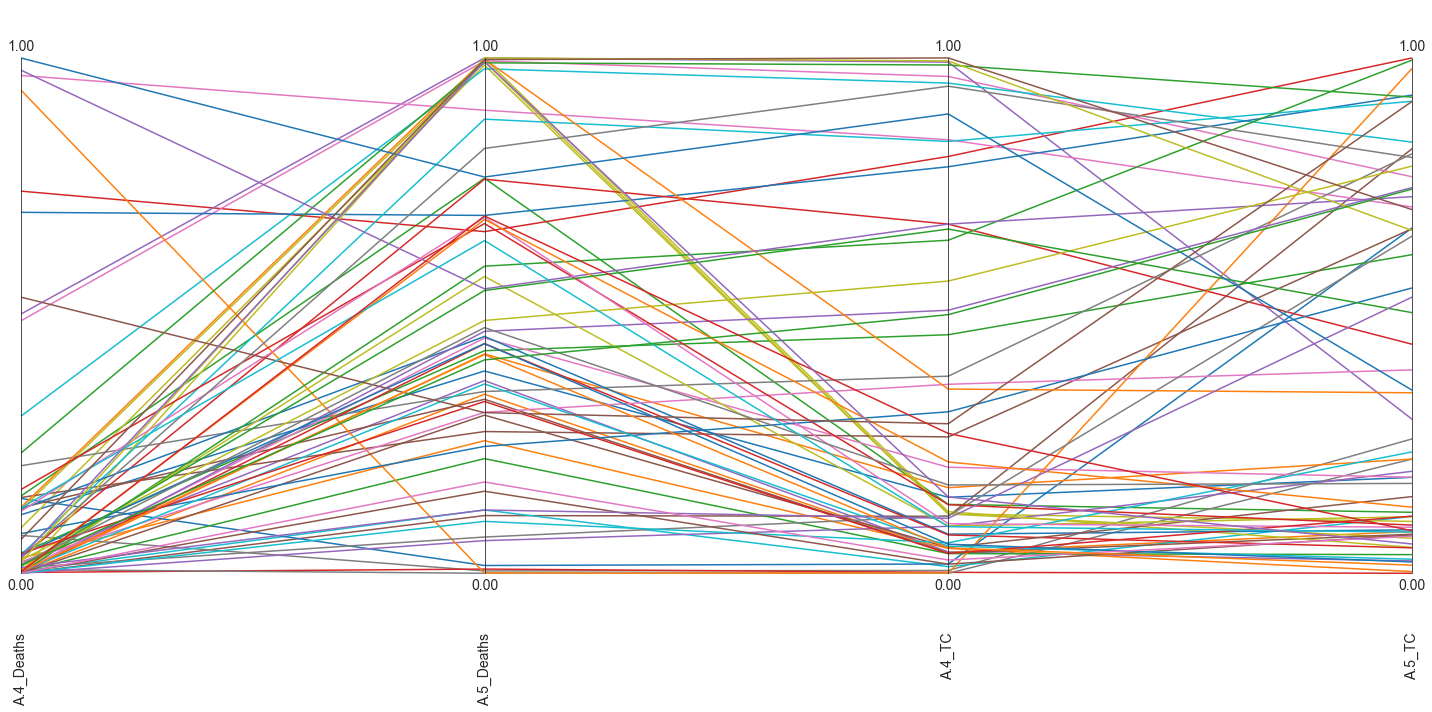

In [37]:
# plotting results
limits = parcoords.get_limits(worst_regret_norm_45)
axes = parcoords.ParallelAxes(limits)
axes.plot(worst_regret_norm_45)
plt.savefig('./figures/minimax_norm_45_undominated.png')

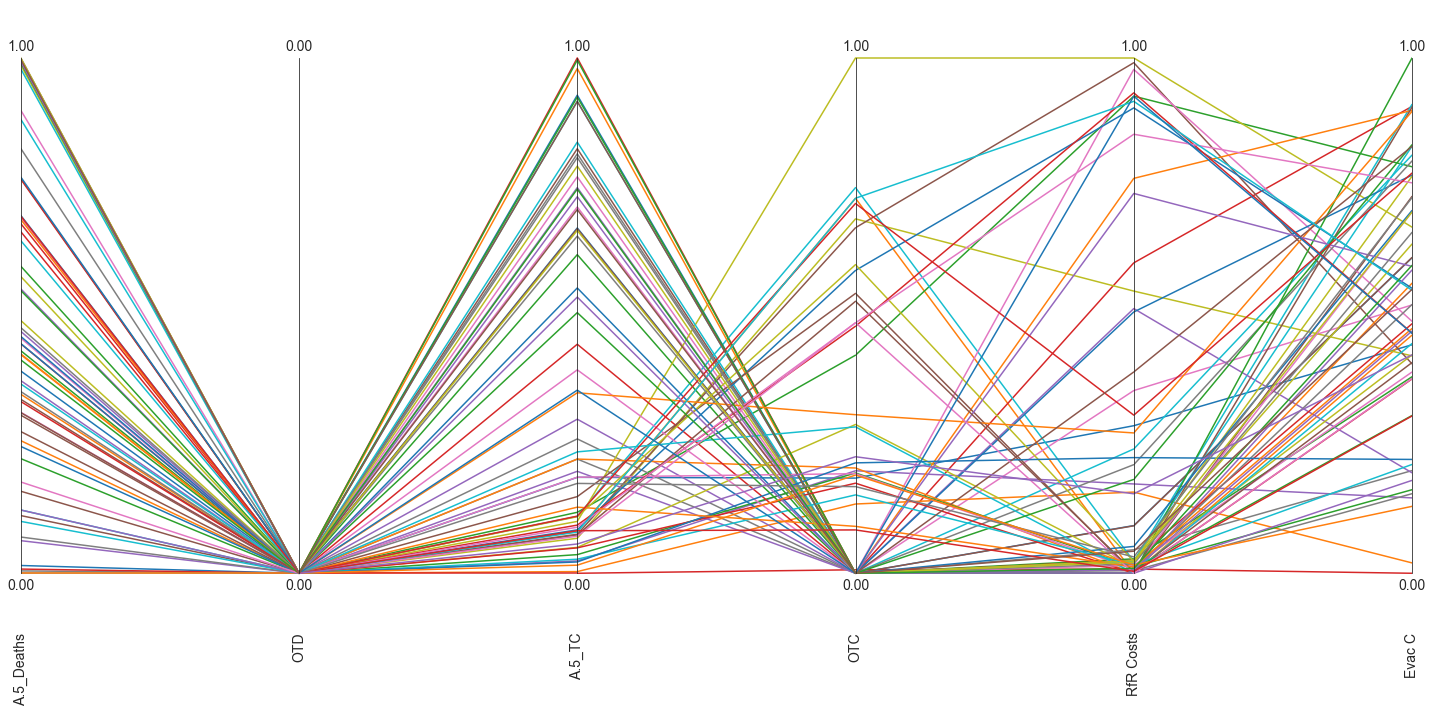

In [38]:
limits = parcoords.get_limits(worst_regret_norm_others5)
axes = parcoords.ParallelAxes(limits)
axes.plot(worst_regret_norm_others5)
plt.savefig('./figures/minimax_norm_others5_undominated.png')

In [39]:
# finding dominating policies
worst_regret_norm_45_dominate = worst_regret_norm_45.drop(dominate(worst_regret_norm_45))
worst_regret_norm_others5_dominate = worst_regret_norm_others5.drop(dominate(worst_regret_norm_others5))

In [40]:
most_pref = most_pref.set_index('policy')

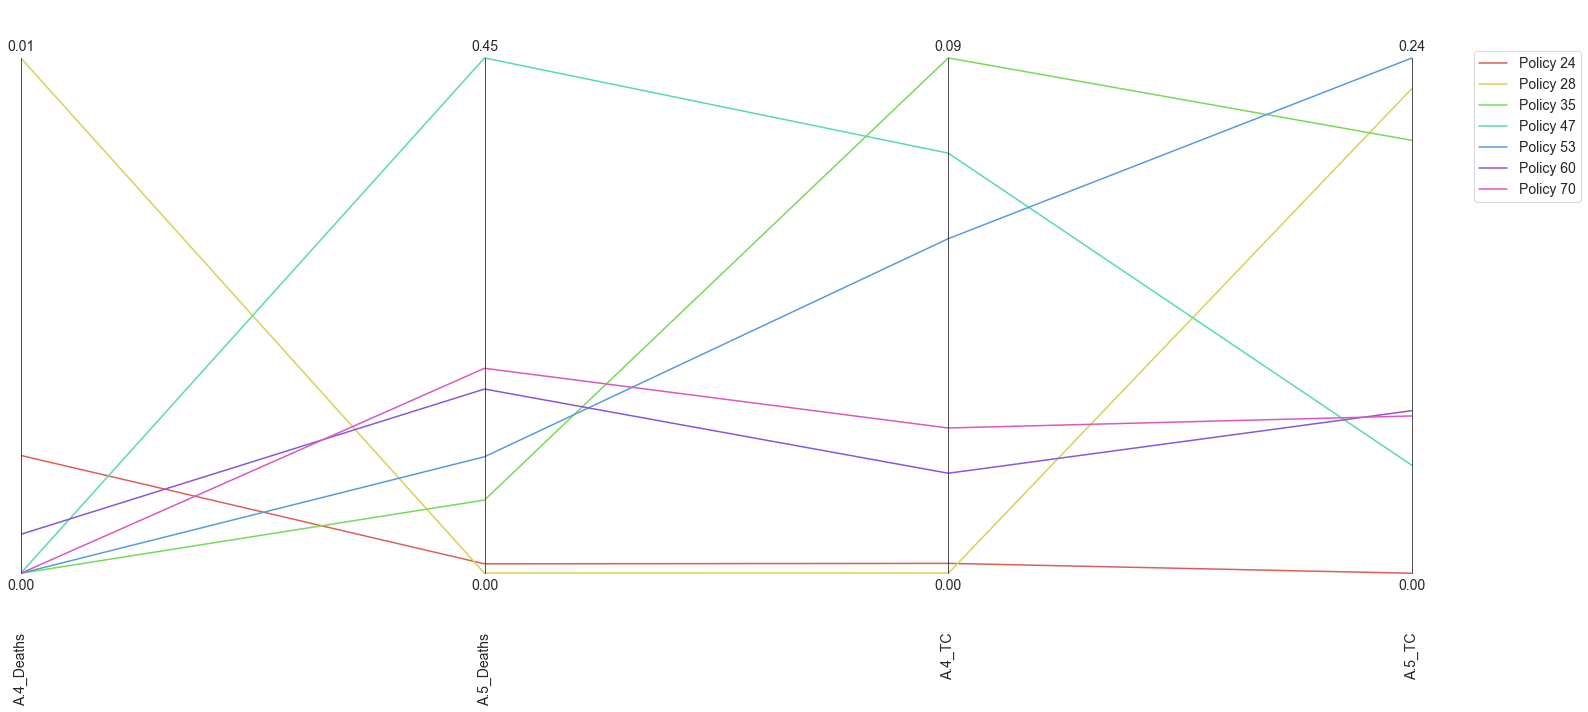

In [41]:
# plotting dominating policies
policies_minimax_45 = axes_paraplot(worst_regret_norm_45_dominate, most_pref, 'minimax_norm_45_dominated')

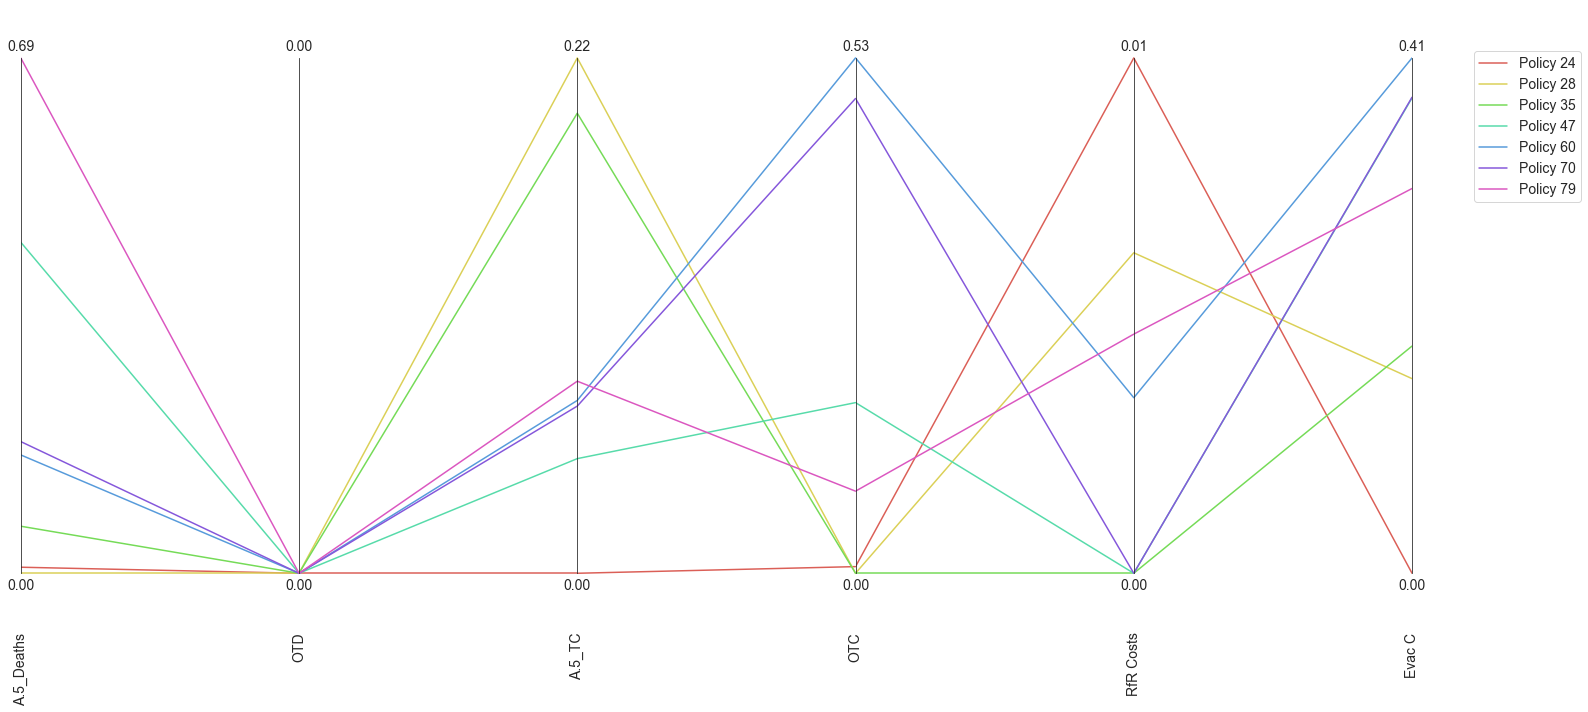

In [42]:
policies_minimax_others5 = axes_paraplot(worst_regret_norm_others5_dominate, most_pref, 'minimax_norm_others5_dominated')

Above, the dominating and in terms of minimax regret well performing policies are plotted. A list of those can be found below.

In [43]:
policies_minimax_45

array(['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 53',
       'Policy 60', 'Policy 70'], dtype=object)

In [44]:
policies_minimax_others5

array(['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60',
       'Policy 70', 'Policy 79'], dtype=object)

#### Table with all the policies
In order to know which policies incorporate which actions i.e. which levers, a table containing policy numbers and levers is created and saved.

In [45]:
policies_levers = experiments_load.groupby('policy').min()
policies_levers = policies_levers[['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]
policies_levers.to_csv('./outcomes/all_policies.csv')

Because Deventer aims to not build or heighten dikes, it is checked whether there are any policies that result in no need to do so. This is unfortunately not the case (see below).

In [46]:
# check if policies with no dike increase in Deventer
no_dike5_increase = policies_levers[(policies_levers['A.5_DikeIncrease 0'] == 0) & (policies_levers['A.5_DikeIncrease 1'] == 0)
                                    & (policies_levers['A.5_DikeIncrease 2'] == 0)]
no_dike5_increase

Empty DataFrame
Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2]
Index: []

[0 rows x 31 columns]

### Find common policies in maximin and minimax regret
We have found policies that are robust regarding the maximin metric, the minimax regret metric, the A.4 vs A.5 and the A.5 vs rest comparison. Now we want to find policies that combine this all. Therefore we check for policies that can be found in all four robust policy outcomes.

In [47]:
# compare minimax A.4 vs A.5 with A.5 vs rest and find common policies
common_minimax_policies = []
for i in range(len(policies_minimax_45)):
    for j in range(len(policies_minimax_others5)):
        if policies_minimax_45[i] == policies_minimax_others5[j]:
            common_minimax_policies.append(policies_minimax_45[i])
common_minimax_policies

['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60', 'Policy 70']

In [48]:
# compare maximin regret A.4 vs A.5 with A.5 vs rest and find common policies
common_maximin_policies = []
for i in range(len(policies_maximin_45)):
    for j in range(len(policies_maximin_others5)):
        if policies_maximin_45[i] == policies_maximin_others5[j]:
            common_maximin_policies.append(policies_maximin_45[i])
common_maximin_policies

['Policy 12',
 'Policy 2',
 'Policy 22',
 'Policy 24',
 'Policy 26',
 'Policy 28',
 'Policy 33',
 'Policy 35',
 'Policy 43',
 'Policy 47',
 'Policy 50',
 'Policy 53',
 'Policy 58',
 'Policy 60',
 'Policy 64',
 'Policy 65',
 'Policy 70',
 'Policy 74',
 'Policy 76']

In [49]:
# compare minimax and maximin regret policies and find common policies
common_robustness_policies = []
for i in range(len(common_minimax_policies)):
    for j in range(len(common_maximin_policies)):
        if common_minimax_policies[i] == common_maximin_policies[j]:
            common_robustness_policies.append(common_minimax_policies[i])
common_robustness_policies

['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60', 'Policy 70']

The above listed policies are undominated on both maximin and minimax regret. There are no other policies that perform better on both these robustness metrics for both rival problem formulations (A.4 vs A.5 and A.5 vs rest).

### Visualisation of results
We have found 6 policies that are promising. In the following we will visualise those results in comparison to all other policies and also in order to see the tradeoffs that still need to be made.

In [50]:
# as a reminder: that is what results_load looks like
results_load.head()

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
0     8.453408e+06                            0.0     1.004570e+08   
1     8.453408e+06                            0.0     9.545879e+07   
2     8.453408e+06                            0.0     1.192903e+08   
3     8.453408e+06                            0.0     9.905568e+07   
4     8.453408e+06                            0.0     9.545879e+07   

   A.5_Expected Number of Deaths  RfR Total Costs  Expected Evacuation Costs  \
0                       0.001221     1.343800e+09                 115.624205   
1                       0.000000     1.343800e+09                  24.535732   
2                       0.011230     1.343800e+09                1135.063294   
3                       0.001133     1.343800e+09                 108.468194   
4                       0.000000     1.343800e+09                   0.000000   

   Other Areas Total Number of Deaths  Other Areas Total Costs    policy  \
0                            0.000000             4.063320e+08  Policy 0   
1                            0.001007             4.092804e+08  Policy 0   
2                            0.000000             4.063320e+08  Policy 0   
3                            0.000000             4.063320e+08  Policy 0   
4                            0.000000             4.063320e+08  Policy 0   

   scenario  A.5_total_dike_increase  
0         0                      8.0  
1         1                      8.0  
2         2                      8.0  
3         3                      8.0  
4         4                      8.0

In [51]:
# group the results by policies so we can compare them
results_policies_mean = results_load.groupby('policy').mean() # we chose mean here. could also be done with min or max
# however, we don't necessarily want the extremes, hence mean. We are aware that there are extremes that could show different tradeoffs
results_policies_mean = results_policies_mean.reset_index()
results_policies_mean

policy  A.4 Total Costs  A.4_Expected Number of Deaths  \
0    Policy 0     9.610063e+06                       0.000174   
1    Policy 1     2.136919e+07                       0.000030   
2   Policy 10     1.998171e+07                       0.000224   
3   Policy 11     1.296303e+07                       0.000915   
4   Policy 12     8.694861e+06                       0.000064   
..        ...              ...                            ...   
61  Policy 76     9.573665e+06                       0.000110   
62  Policy 78     1.308537e+07                       0.000241   
63  Policy 79     4.284273e+07                       0.002539   
64   Policy 8     3.743308e+07                       0.002130   
65   Policy 9     3.081054e+07                       0.011579   

    A.5 Total Costs  A.5_Expected Number of Deaths  RfR Total Costs  \
0      1.064395e+08                       0.003585     1.343800e+09   
1      1.462890e+08                       0.000000     4.789000e+08   
2      1.361835e+08                       0.007950     0.000000e+00   
3      1.224428e+08                       0.046797     0.000000e+00   
4      1.384927e+08                       0.000463     2.015900e+09   
..              ...                            ...              ...   
61     1.390015e+08                       0.000007     1.792200e+09   
62     1.303513e+08                       0.000012     2.365000e+08   
63     1.643520e+08                       0.000003     1.153000e+08   
64     8.022001e+07                       0.000147     8.460000e+07   
65     8.469014e+07                       0.000139     1.460000e+08   

    Expected Evacuation Costs  Other Areas Total Number of Deaths  \
0                 1077.310989                            0.020136   
1                13402.329710                            0.035689   
2                13484.850827                            0.089687   
3                    0.000000                            0.584468   
4                 1916.777293                            0.004713   
..                        ...                                 ...   
61                1592.325021                            0.002686   
62                   0.000000                            0.399561   
63                 816.931236                            0.008175   
64                4985.550637                            0.012951   
65                   0.000000                            0.097334   

    Other Areas Total Costs  scenario  A.5_total_dike_increase  
0              4.657542e+08     499.5                      8.0  
1              4.235641e+08     499.5                     16.0  
2              1.058403e+09     499.5                      3.0  
3              9.335008e+08     499.5                      8.0  
4              7.153672e+08     499.5                     16.0  
..                      ...       ...                      ...  
61             3.022463e+08     499.5                     16.0  
62             5.058562e+08     499.5                     13.0  
63             5.200713e+08     499.5                     18.0  
64             3.502365e+08     499.5                      9.0  
65             4.043994e+08     499.5                     10.0  

[66 rows x 11 columns]

In [52]:
# make a dataframe containing the results for the 6 robust policies
robust_policies_results = []
robust_policies_results_index = []

for i in range(len(results_policies_mean)):
    if results_policies_mean.loc[i, 'policy'] in common_robustness_policies:
        robust_policies_results.append(results_policies_mean.iloc[i])
        robust_policies_results_index.append(i)
    else:
        pass
robust_policies_results

policy_names = results_policies_mean['policy'][robust_policies_results_index].reset_index(drop=True) # for legend

In [53]:
outcomes_array_policy = outcomes_array + ['policy']
outcomes_array_policy

['A.4 Total Costs',
 'A.4_Expected Number of Deaths',
 'A.5 Total Costs',
 'A.5_Expected Number of Deaths',
 'RfR Total Costs',
 'Expected Evacuation Costs',
 'Other Areas Total Number of Deaths',
 'Other Areas Total Costs',
 'A.5_total_dike_increase',
 'policy']

In [54]:
# turn the list into a dataframe
robust_policies_results_DF = pd.DataFrame(robust_policies_results, columns=outcomes_array)
robust_policies_results_DF

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
13     8.443986e+07                   1.511502e-07     1.196257e+08   
17     5.332187e+07                   0.000000e+00     8.818141e+07   
24     2.297415e+07                   2.155079e-05     1.294640e+08   
33     2.172859e+07                   3.101994e-04     8.122223e+07   
45     2.762181e+07                   1.327971e-05     1.614505e+08   
56     2.172088e+07                   9.128186e-06     9.043017e+07   

    A.5_Expected Number of Deaths  RfR Total Costs  Expected Evacuation Costs  \
13                   5.337911e-06     1.126400e+09                   5.325871   
17                   5.766673e-06     2.100500e+09                   0.000000   
24                   0.000000e+00     1.098800e+09                   0.000000   
33                   0.000000e+00     3.943000e+08                1721.427482   
45                   4.356840e-07     1.336200e+09                6385.535460   
56                   0.000000e+00     5.635000e+08                2316.819576   

    Other Areas Total Number of Deaths  Other Areas Total Costs  \
13                            0.000006             6.945792e+08   
17                            0.020691             5.615959e+08   
24                            0.030967             2.941586e+08   
33                            0.009712             6.291756e+08   
45                            0.021021             2.486441e+08   
56                            0.008339             3.768514e+08   

    A.5_total_dike_increase  
13                     11.0  
17                     11.0  
24                     13.0  
33                      9.0  
45                     19.0  
56                     11.0

In the following some restructuring of the two dataframes (one with the results of all policies, one with the robust policies results) is carried out. This is done in order to ensure a smooth visualisation.

In [55]:
short_names_dike_increase = short_names + ['A.5_Dike']

In [56]:
robust_policies_results_DF = robust_policies_results_DF.set_axis(short_names_dike_increase, axis=1)
robust_policies_results_DF = robust_policies_results_DF.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5_Dike'])

In [57]:
results_policies_mean = results_policies_mean.drop(['scenario', 'policy'], axis = 1)
results_policies_mean = results_policies_mean.set_axis(short_names_dike_increase, axis=1)
results_policies_mean = results_policies_mean.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5_Dike'])

In [58]:
results_policies_mean

A.4_Deaths  A.5_Deaths       OTD        A.4_TC        A.5_TC  \
0     0.000174    0.003585  0.020136  9.610063e+06  1.064395e+08   
1     0.000030    0.000000  0.035689  2.136919e+07  1.462890e+08   
2     0.000224    0.007950  0.089687  1.998171e+07  1.361835e+08   
3     0.000915    0.046797  0.584468  1.296303e+07  1.224428e+08   
4     0.000064    0.000463  0.004713  8.694861e+06  1.384927e+08   
..         ...         ...       ...           ...           ...   
61    0.000110    0.000007  0.002686  9.573665e+06  1.390015e+08   
62    0.000241    0.000012  0.399561  1.308537e+07  1.303513e+08   
63    0.002539    0.000003  0.008175  4.284273e+07  1.643520e+08   
64    0.002130    0.000147  0.012951  3.743308e+07  8.022001e+07   
65    0.011579    0.000139  0.097334  3.081054e+07  8.469014e+07   

             OTC     RfR Costs        Evac C  A.5_Dike  
0   4.657542e+08  1.343800e+09   1077.310989       8.0  
1   4.235641e+08  4.789000e+08  13402.329710      16.0  
2   1.058403e+09  0.000000e+00  13484.850827       3.0  
3   9.335008e+08  0.000000e+00      0.000000       8.0  
4   7.153672e+08  2.015900e+09   1916.777293      16.0  
..           ...           ...           ...       ...  
61  3.022463e+08  1.792200e+09   1592.325021      16.0  
62  5.058562e+08  2.365000e+08      0.000000      13.0  
63  5.200713e+08  1.153000e+08    816.931236      18.0  
64  3.502365e+08  8.460000e+07   4985.550637       9.0  
65  4.043994e+08  1.460000e+08      0.000000      10.0  

[66 rows x 9 columns]

In [59]:
robust_policies_results_DF

A.4_Deaths    A.5_Deaths       OTD        A.4_TC        A.5_TC  \
13  1.511502e-07  5.337911e-06  0.000006  8.443986e+07  1.196257e+08   
17  0.000000e+00  5.766673e-06  0.020691  5.332187e+07  8.818141e+07   
24  2.155079e-05  0.000000e+00  0.030967  2.297415e+07  1.294640e+08   
33  3.101994e-04  0.000000e+00  0.009712  2.172859e+07  8.122223e+07   
45  1.327971e-05  4.356840e-07  0.021021  2.762181e+07  1.614505e+08   
56  9.128186e-06  0.000000e+00  0.008339  2.172088e+07  9.043017e+07   

             OTC     RfR Costs       Evac C  A.5_Dike  
13  6.945792e+08  1.126400e+09     5.325871      11.0  
17  5.615959e+08  2.100500e+09     0.000000      11.0  
24  2.941586e+08  1.098800e+09     0.000000      13.0  
33  6.291756e+08  3.943000e+08  1721.427482       9.0  
45  2.486441e+08  1.336200e+09  6385.535460      19.0  
56  3.768514e+08  5.635000e+08  2316.819576      11.0

Below the visualisation of the robust policies in comparison to the other policies is visualised. 

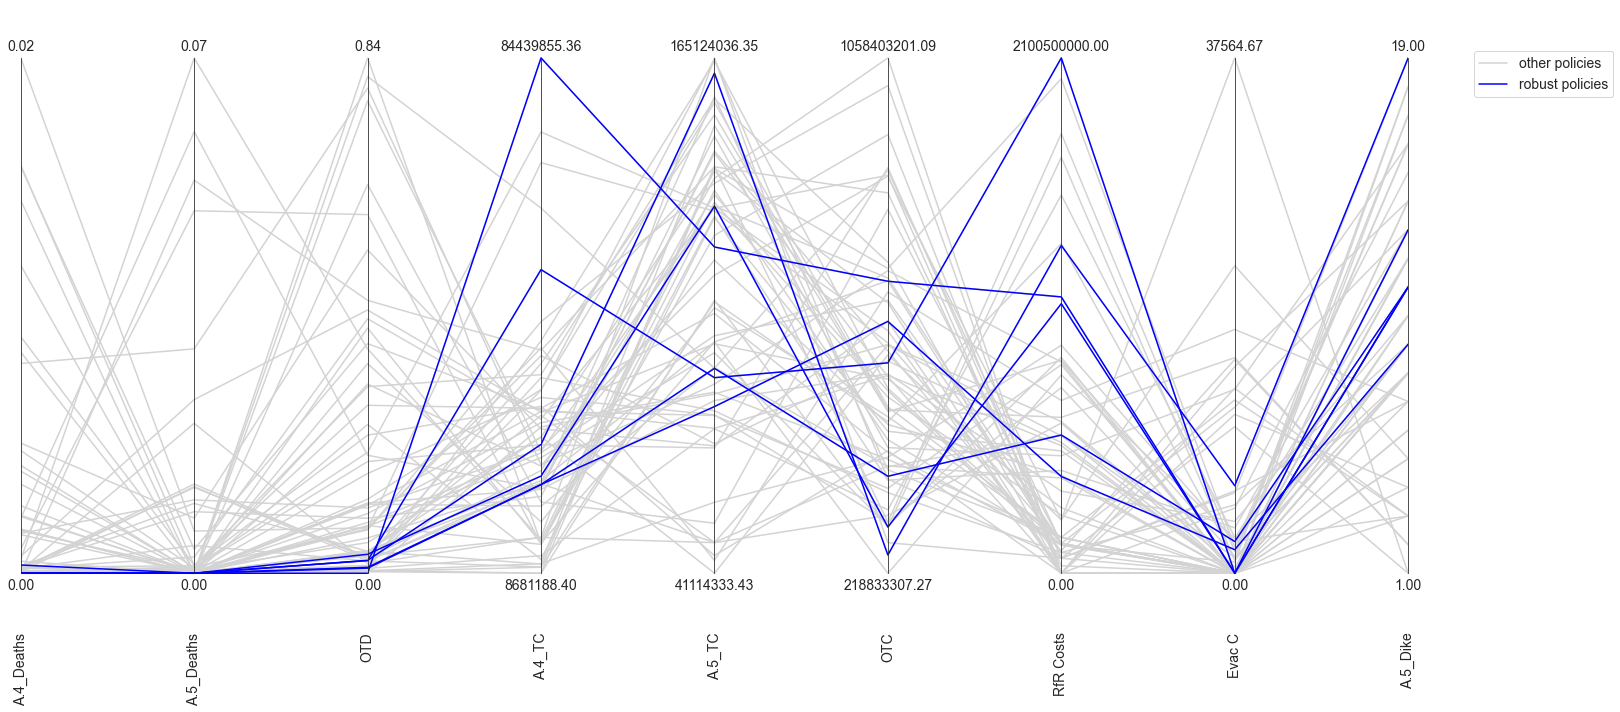

In [62]:
limits = parcoords.get_limits(results_policies_mean)
axes = parcoords.ParallelAxes(limits)

axes.plot(results_policies_mean, color='lightgrey', label = 'other policies')
axes.plot(robust_policies_results_DF, color='blue', label = 'robust policies')
axes.legend()
plt.savefig('./figures/robust_policies_comparison_to_other_policies_blue.png')
plt.show()


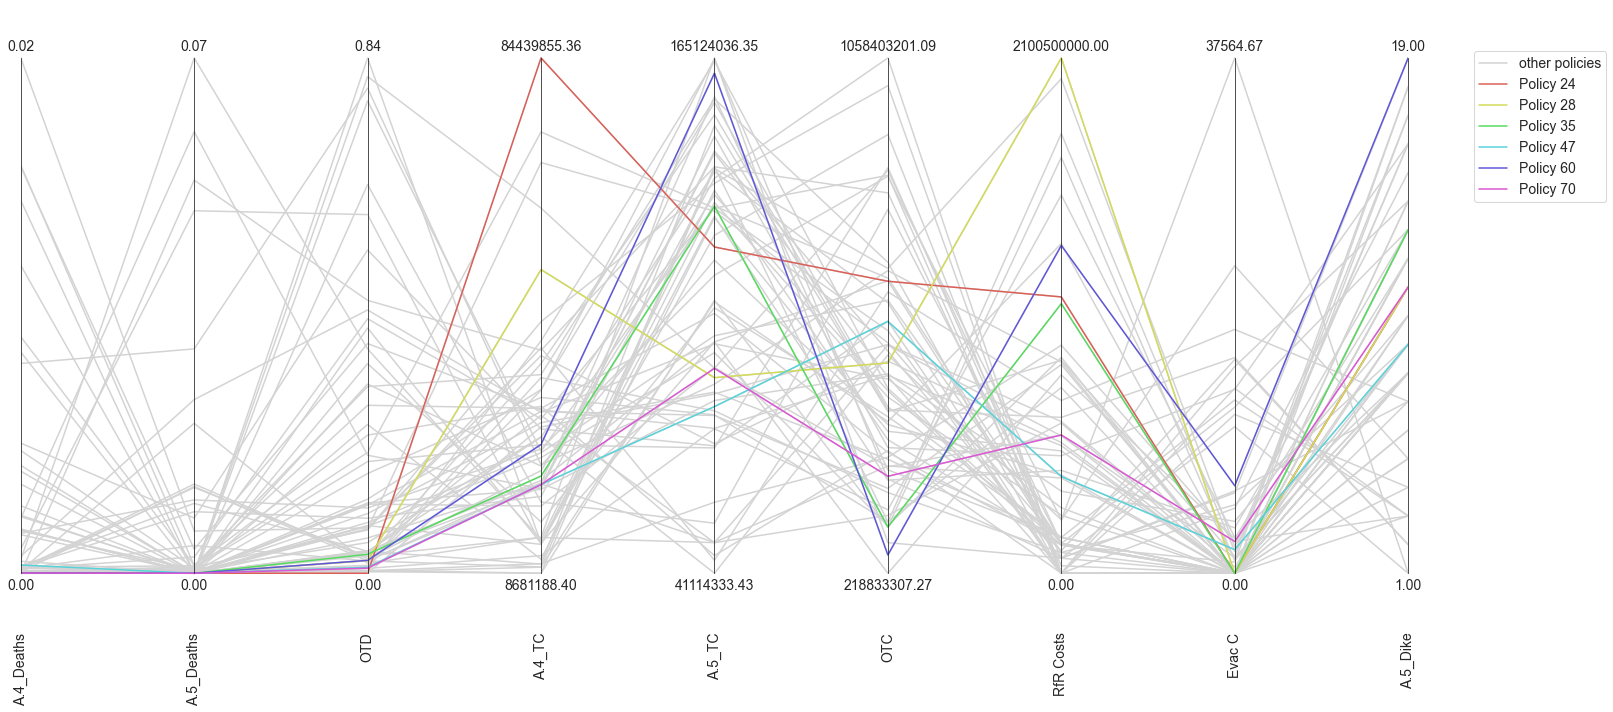

In [64]:
limits = parcoords.get_limits(results_policies_mean)
axes = parcoords.ParallelAxes(limits)

axes.plot(results_policies_mean, color='lightgrey', label = 'other policies')

dominate_policy = robust_policies_results_DF

for i in range(len(dominate_policy)):   
    axes.plot(dominate_policy.iloc[i], label=policy_names[i], color=sns.color_palette('hls', len(dominate_policy))[i])
axes.legend()

plt.savefig('./figures/robust_policies_comparison_to_other_policies_legend_mean.png')
plt.show()